# Messing around with Prophet

## Set up

In [1]:
import pandas as pd
from prophet import Prophet

In [2]:
dates = ['2021-01-07',

'2021-01-10',

'2021-01-11',

'2021-01-12',

'2021-02-11',

'2021-02-12',

'2021-03-09',

'2021-03-11',

'2021-03-12',

'2021-04-08',

'2021-04-10',

'2021-04-11',

'2021-04-12',

'2021-05-08',

'2021-05-10',

'2021-05-11',

'2021-06-08',

'2021-06-09',

'2021-06-10',

'2021-06-12',

'2021-06-28',

'2021-07-10',

'2021-07-12',

'2021-07-21',

'2021-07-28',

'2021-07-30',

'2021-08-07',

'2021-08-09',

'2021-08-10',

'2021-08-11',

'2021-08-12',

'2021-08-13',

'2021-08-17',

'2021-08-18',

'2021-08-19',

'2021-08-20',

'2021-08-23',

'2021-08-25',

'2021-08-26',

'2021-08-27',

'2021-09-08',

'2021-09-11',

'2021-09-12',

'2021-09-13',

'2021-09-14',

'2021-09-15',

'2021-09-16',

'2021-09-17',

'2021-09-20',

'2021-09-21',

'2021-09-23',

'2021-09-24',

'2021-09-27',

'2021-09-28',

'2021-09-29',

'2021-09-30',

'2021-10-09',

'2021-10-11',

'2021-10-12',

'2021-10-13',

'2021-10-14',

'2021-10-15',

'2021-10-18',

'2021-10-19',

'2021-10-20',

'2021-10-21',

'2021-10-22',

'2021-10-25',

'2021-10-26',

'2021-10-27',

'2021-10-28',

'2021-10-29',

'2021-11-08',

'2021-11-10',

'2021-11-11',

'2021-11-15',

'2021-11-16',

'2021-11-17',

'2021-11-18',

'2021-11-19',

'2021-11-22',

'2021-11-23',

'2021-11-24',

'2021-11-25',

'2021-11-26',

'2021-11-29',

'2021-11-30',

'2021-12-07',

'2021-12-10',

'2021-12-11',

'2021-12-13',

'2021-12-14',

'2021-12-15',

'2021-12-16',

'2021-12-17',

'2021-12-20',

'2021-12-21',

'2021-12-22',

'2021-12-23',

'2021-12-24',

'2021-12-27',

'2021-12-28',

'2021-12-30',

'2022-01-02',

'2022-01-03',

'2022-01-04',

'2022-01-06',

'2022-01-07',

'2022-01-08',

'2022-01-09',

'2022-01-13',

'2022-01-14',

'2022-01-16',

'2022-01-17',

'2022-01-18',

'2022-01-19',

'2022-01-20',

'2022-01-21',

'2022-01-24',

'2022-01-25',

'2022-01-26',

'2022-01-27',

'2022-01-28',

'2022-01-31',

'2022-02-02',

'2022-02-03',

'2022-02-05',

'2022-02-06',

'2022-02-08',

'2022-02-09',

'2022-02-14',

'2022-02-15',

'2022-02-16',

'2022-02-17',

'2022-02-18',

'2022-02-21',

'2022-02-22',

'2022-02-23',

'2022-02-24',

'2022-02-25',

'2022-02-26',

'2022-02-28',

'2022-03-01',

'2022-03-02',

'2022-03-03',

'2022-03-05',

'2022-03-06',

'2022-03-08',

'2022-03-14',

'2022-03-15',

'2022-03-16',

'2022-03-17',

'2022-03-18',

'2022-03-21',

'2022-03-22',

'2022-03-23',

'2022-03-24',

'2022-03-25',

'2022-03-28',

'2022-03-29',

'2022-03-30',

'2022-03-31',

'2022-04-01',

'2022-04-02',

'2022-04-03',

'2022-04-04',

'2022-04-05',

'2022-04-07',

'2022-04-08',

'2022-04-09',

'2022-04-13',

'2022-04-14',

'2022-04-15',

'2022-04-19',

'2022-04-20',

'2022-04-21',

'2022-04-22',

'2022-04-25',

'2022-04-26',

'2022-04-27',

'2022-04-28',

'2022-04-29',

'2022-05-01',

'2022-05-04',

'2022-05-05',

'2022-05-07',

'2022-05-08',

'2022-05-13',

'2022-05-16',

'2022-05-17',

'2022-05-18',

'2022-05-19',

'2022-05-20',

'2022-05-21',

'2022-05-23',

'2022-05-24',

'2022-05-25',

'2022-05-26',

'2022-05-27',

'2022-05-28',

'2022-05-30',

'2022-05-31',

'2022-06-01',

'2022-06-04',

'2022-06-05',

'2022-06-06',

'2022-06-07',

'2022-06-13',

'2022-06-14',

'2022-06-15',

'2022-06-16',

'2022-06-17',

'2022-06-20',

'2022-06-21',

'2022-06-22',

'2022-06-23',

'2022-06-24',

'2022-06-27',

'2022-06-28',

'2022-06-29',

'2022-06-30',

'2022-07-01',

'2022-07-02',

'2022-07-03',

'2022-07-04',

'2022-07-06',

'2022-07-07',

'2022-07-13',

'2022-07-14',

'2022-07-15',

'2022-07-18',

'2022-07-19',

'2022-07-20',

'2022-07-21',

'2022-07-22',

'2022-07-25',

'2022-07-26',

'2022-07-27',

'2022-07-28',

'2022-07-29',

'2022-08-02',

'2022-08-03',

'2022-08-04',

'2022-08-06',

'2022-08-07',

'2022-08-08',

'2022-08-14',

'2022-08-15',

'2022-08-16',

'2022-08-17',

'2022-08-18',

'2022-08-19',

'2022-08-22',

'2022-08-23',

'2022-08-24',

'2022-08-25',

'2022-08-26',

'2022-08-29',

'2022-08-30',

'2022-08-31',

'2022-09-02',

'2022-09-03',

'2022-09-04',

'2022-09-05',

'2022-09-06',

'2022-09-07',

'2022-09-08',

'2022-10-01',

'2022-10-02',

'2022-10-03',

'2022-10-05',

'2022-10-06',

'2022-10-08',

'2022-11-01',

'2022-11-02',

'2022-11-03',

'2022-11-04',

'2022-11-05',

'2022-11-07',

'2022-11-08',

'2022-12-01',

'2022-12-04',

'2022-12-05',

'2022-12-07',

'2022-12-08']

In [3]:
patients = [1,

2,

2,

9,

6,

5,

3,

11,

2,

3,

1,

8,

1,

3,

4,

3,

1,

2,

1,

4,

1,

4,

8,

3,

2,

1,

2,

3,

1,

2,

3,

1,

1,

3,

3,

1,

2,

2,

4,

1,

1,

4,

6,

2,

1,

3,

1,

1,

1,

5,

5,

1,

3,

6,

5,

2,

1,

4,

1,

4,

9,

5,

5,

3,

5,

3,

4,

4,

10,

4,

3,

4,

2,

5,

5,

5,

10,

3,

10,

6,

5,

3,

6,

8,

4,

8,

10,

1,

1,

7,

7,

6,

4,

6,

1,

8,

2,

6,

4,

2,

1,

3,

2,

13,

5,

5,

13,

7,

5,

3,

4,

6,

2,

9,

6,

13,

7,

8,

7,

14,

10,

11,

5,

3,

10,

14,

3,

11,

5,

2,

8,

18,

13,

8,

8,

7,

9,

9,

12,

8,

1,

8,

2,

6,

15,

7,

5,

9,

8,

9,

13,

8,

10,

7,

9,

5,

6,

5,

5,

7,

10,

19,

9,

4,

7,

11,

5,

2,

7,

1,

9,

7,

3,

10,

6,

10,

4,

7,

6,

3,

11,

6,

4,

15,

9,

8,

3,

9,

10,

11,

7,

12,

6,

1,

5,

13,

14,

10,

6,

1,

7,

5,

4,

3,

7,

4,

12,

8,

4,

8,

10,

4,

1,

9,

9,

11,

5,

6,

9,

8,

12,

3,

8,

5,

10,

4,

13,

7,

7,

4,

3,

6,

3,

11,

7,

5,

3,

9,

2,

2,

4,

6,

3,

12,

8,

7,

1,

4,

4,

9,

14,

3,

4,

5,

5,

3,

2,

2,

6,

5,

6,

9,

1,

13,

11,

1,

9,

6,

6,

13,

15,

6,

4,

4,

3,

7,

9,

4,

8,

4,

3,

11,

8,

12,

4]

## Data Preprocessing

In [4]:
patients[:5]

[1, 2, 2, 9, 6]

In [5]:
dates[:5]

['2021-01-07', '2021-01-10', '2021-01-11', '2021-01-12', '2021-02-11']

In [6]:
df = pd.DataFrame({"date":dates, "patient_count":patients})
df.head()

,date,patient_count
0,2021-01-07,1
1,2021-01-10,2
2,2021-01-11,2
3,2021-01-12,9
4,2021-02-11,6


In [7]:
# Change dates to datetime objects
df['date'] = pd.to_datetime(df['date'])
df.dtypes

date             datetime64[ns]
patient_count             int64
dtype: object

In [8]:
# Rename column names to 'ds' for the dates and 'y' for the values.
# This is for use with prophet
df.columns = ['ds', 'y']

df.head()

,ds,y
0,2021-01-07,1
1,2021-01-10,2
2,2021-01-11,2
3,2021-01-12,9
4,2021-02-11,6


In [9]:
# resampling dates as monthly aggregates
df_monthly = df.set_index('ds').resample('M').sum()
df_monthly = df_monthly.reset_index()

df_monthly.head()

,ds,y
0,2021-01-31,14
1,2021-02-28,11
2,2021-03-31,16
3,2021-04-30,13
4,2021-05-31,10


## Forecasting

In [10]:
# Train the model
m = Prophet(interval_width=0.95)
model = m.fit(df)

19:20:32 - cmdstanpy - INFO - Chain [1] start processing
19:20:32 - cmdstanpy - INFO - Chain [1] done processing


In [25]:
# Creating the future dates to forcast
future_dates = model.make_future_dataframe(periods=12, freq='M')
future_dates.head()

,ds
0,2021-01-07
1,2021-01-10
2,2021-01-11
3,2021-01-12
4,2021-02-11


In [26]:
# Forecasting output
forecast = m.predict(future_dates)
forecast.head()

,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,additive_terms,additive_terms_lower,additive_terms_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat
0,2021-01-07,22.264072,-72.886227,113.559546,22.264072,22.264072,0.0,0.0,0.0,0.0,0.0,0.0,22.264072
1,2021-01-10,22.647434,-73.029035,118.487411,22.647434,22.647434,0.0,0.0,0.0,0.0,0.0,0.0,22.647434
2,2021-01-11,22.775221,-68.652410,111.318289,22.775221,22.775221,0.0,0.0,0.0,0.0,0.0,0.0,22.775221
3,2021-01-12,22.903008,-70.282226,105.416935,22.903008,22.903008,0.0,0.0,0.0,0.0,0.0,0.0,22.903008
4,2021-02-11,26.736624,-64.132587,117.121897,26.736624,26.736624,0.0,0.0,0.0,0.0,0.0,0.0,26.736624


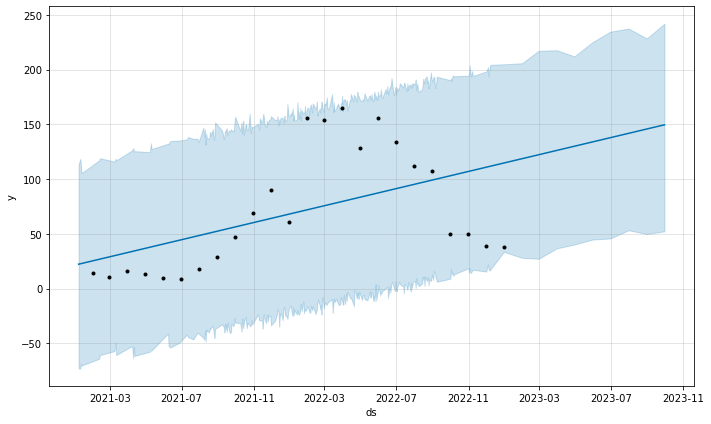

In [27]:
# Forecast plot
plot1 = m.plot(forecast)

In [29]:
# # forecasting with monthly dataframe

# # Fit model
# m = Prophet(interval_width=0.95)
# model2 = m.fit(df_monthly)

# # Creating the future dates
# future_dates2 = model.make_future_dataframe(periods=12, freq='M')
# future_dates2.head()

# # Forecasting output
# forecast = m.predict(future_dates2)

# # Forecast plot
# plot2 = m.plot(forecast)

Some notes about what Prophet is doing: <br>
You'll note that I've made no attempt at making the data stationary before shoving it into a model, but apparently the model that prophet is using isn't concerned with stationarity... <br>
*"No. Stationarity is an important condition for some other time series forecasting algorithms such as ARMA or ARIMA, but prophet assumes nothing about stationarity. Prophet rather makes use of features like trend or seasonality, which stationary data by definition do not have"*
<br><br>
I'll probably want to learn how to intepret the plot and dataframe that prophet has output above, next.
...